In [1]:
#Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

#Load data and make a copy
df = pd.read_excel("Comp Model 2019 for Optimization.xlsx", sheet_name = 'percent_wksht', skiprows=2)
dc = df.copy()

#drop negative rows values in 'Net Sale $' column
dc = dc.query("~(Net_Sale_Amount < 0)")
#dc['ID'] = dc['Match ID'].str.split('-').str[1]

#Rename columns needed for data munging
df_kp = dc.copy()
df_grp = df_kp.rename(columns={'Current Commission': 'Current_Commission', 'Net Sales': 'Net_Sales', 'Close Rate': 
                                  'Close_Rate', 'Handle Time': 'Handle_Time', 'Net_Sale_Amount': 'Net_Sale_amt', 
                                  'Adj Net Sale': 'Adj_Net_Sale', 'Close Rate Score': 'Close_Rate_Score', 
                                  'Payout Rate': 'Payout_Rate', 'Current Commission per Hour': 'Current_Comm_Per_Hour'})


group = df_grp.groupby(['ID','Market','Gate'])
grp = group.aggregate({'Current_Commission':'sum'})
grp['Current Comm Per Hour'] = df_grp.groupby(['ID','Market','Gate']).Current_Comm_Per_Hour.mean()
grp['Net Sales'] = df_grp.groupby(['ID','Market','Gate']).Net_Sales.sum()
grp['Close Rate'] = df_grp.groupby(['ID','Market','Gate']).Close_Rate.mean()
grp['Handle Time'] = df_grp.groupby(['ID','Market','Gate']).Handle_Time.sum()
grp['Net Sales Amount'] = df_grp.groupby(['ID','Market','Gate']).Net_Sale_amt.sum()
grp['Adj Net Sale'] = df_grp.groupby(['ID','Market','Gate']).Adj_Net_Sale.sum()
grp['Close Rate Score'] = df_grp.groupby(['ID','Market','Gate']).Close_Rate_Score.mean()
grp['Payout Rate'] = df_grp.groupby(['ID','Market','Gate']).Payout_Rate.mean()
grp.reset_index(drop=False,inplace=True)

grp['Commission_Rate'] = round(grp['Current_Commission']/grp['Net Sales Amount'],2).replace(np.nan, 0)
grp = grp.round({'Current_Commission': 2, 'Current Comm Per Hour': 2, 'Close Rate': 2, 
                 'Net Sales': 2,'Net Sales Amount': 2})
df_needed = grp[['ID','Market','Gate','Handle Time','Current_Commission','Current Comm Per Hour',
                 'Commission_Rate','Close Rate','Net Sales','Net Sales Amount']]

In [2]:
df_needed.head(3)

,ID,Market,Gate,Handle Time,Current_Commission,Current Comm Per Hour,Commission_Rate,Close Rate,Net Sales,Net Sales Amount
0,1003781460,WP,Dev,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,1003781460,WP,DevSP,142.46,730.53,4.13,0.01,0.11,309.01,77878.21
2,1003781460,WP,Prem,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [3]:
df_needed['ID'].isnull().sum()

0

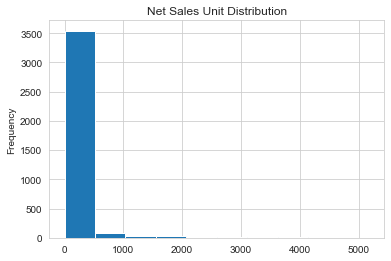

In [4]:
df_needed['Net Sales'].plot(kind='hist', title='Net Sales Unit Distribution')

In [5]:
df_needed.Market.value_counts()

West Hills Inbound               1095
West Hills (English) Outbound     772
WP                                653
Spokane (English) Outbound        425
Miami (English) Outbound          408
Spokane PARS                      318
Miami (Spanish) Outbound           48
West Hills (Spanish) Outbound      18
Spokane (Spanish) Outbound          6
Name: Market, dtype: int64

In [6]:
#Split into different Market Groups

West_Hills = (df_needed[(df_needed['Market'] == 'West Hills Inbound') \
                        | (df_needed['Market'] == 'West Hills (English) Outbound' ) 
                        | (df_needed['Market'] == 'West Hills (Spanish) Outbound' )])

Spokane = df_needed[df_needed["Market"].isin(['Spokane (English) Outbound','Spokane (Spanish) Outbound ','Spokane PARS'])]

Miami = df_needed[df_needed["Market"].isin(['Miami (English) Outbound','Miami (Spanish) Outbound'])]

WP = df_needed[df_needed["Market"].isin(['WP'])]

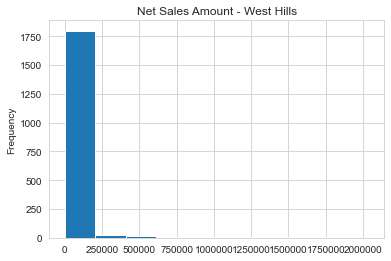

In [9]:
plt.ticklabel_format(style='plain', axis='x')
West_Hills['Net Sales Amount'].plot(kind='hist', title='Net Sales Amount - West Hills')

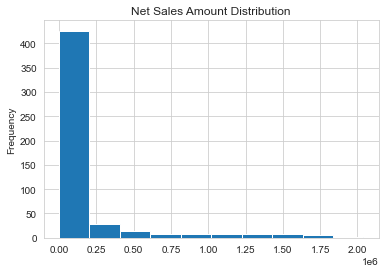

In [10]:
noZero_West_Hills = West_Hills.rename(columns={'Net Sales Amount': 'Net_Sales_Amount'})
noZero_West_Hills = noZero_West_Hills.query("~(Net_Sales_Amount <= 0)")
noZero_West_Hills['Net_Sales_Amount'].plot(kind='hist', title='Net Sales Amount Distribution')

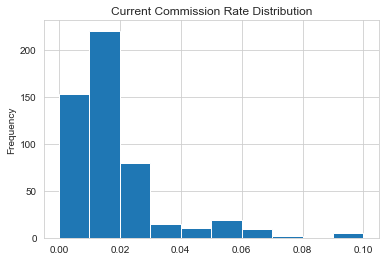

In [11]:
noZero_West_Hills['Commission_Rate'].plot(kind='hist', title='Current Commission Rate Distribution')

In [12]:
df_noNegative = noZero_West_Hills[(noZero_West_Hills['Close Rate'] >= 0)]
df_noNegative['Close Rate'].describe(percentiles=[0.00, 0.05,.25, .5, .75, 1.00])

count    511.000000
mean       0.161977
std        0.160348
min        0.000000
0%         0.000000
5%         0.010000
25%        0.040000
50%        0.100000
75%        0.245000
100%       0.670000
max        0.670000
Name: Close Rate, dtype: float64

In [13]:
df_noNegative.ID.nunique()

203

# Net Sales Amount Prediction Analysis - West_Hills

In [12]:
df_noNegative.to_excel('WH_For_Prediction.xlsx', index=False)

In [14]:
import math
import scipy
import scipy
import warnings
import seaborn as sns
from tkinter import font
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.compat import lzip
import statsmodels.formula.api as smf
from sklearn.preprocessing import scale
from scipy.stats import norm, skew,kurtosis
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.metrics import explained_variance_score,r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor
pd.options.display.float_format = '{:.2f}'.format

warnings.filterwarnings('ignore')
df_wh = pd.read_excel("WH_For_Prediction.xlsx")

dz = df_wh.copy()
df = dz[['Handle Time','Current_Commission','Current Comm Per Hour','Commission_Rate',
         'Close Rate','Net Sales','Net_Sales_Amount']]

Y=df["Net_Sales_Amount"]
X=df[['Handle Time','Commission_Rate','Current_Commission','Current Comm Per Hour','Close Rate','Net Sales']]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465) 
print('Training Data Count: {}'.format(X_train.shape[0]))
print('Testing Data Count: {}'.format(X_test.shape[0]))

Training Data Count: 408
Testing Data Count: 103


In [15]:
X_train = sm.add_constant(X_train)
results = sm.OLS(y_train, X_train).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Net_Sales_Amount   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                     957.9
Date:                Mon, 20 Jul 2020   Prob (F-statistic):          3.45e-234
Time:                        08:49:18   Log-Likelihood:                -5246.4
No. Observations:                 408   AIC:                         1.051e+04
Df Residuals:                     401   BIC:                         1.053e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -6258.3297      1e+04     -0.624      0.533    -2.6e+04    1.35e+04
Handle Time             -29.0449     58.987     -0.492      0.623    -145.007      86.917
Commission_Rate       -4.276e+05   3.22e+05     -1.326      0.186   -1.06e+06    2.06e+05
Current_Commission       34.2694      3.152     10.872      0.000      28.073      40.466
Current Comm Per Hour  -343.0630    638.756     -0.537      0.592   -1598.792     912.666
Close Rate              1.92e+05   5.65e+04      3.398      0.001    8.09e+04    3.03e+05
Net Sales               225.2256     29.503      7.634      0.000     167.225     283.226
==============================================================================
Omnibus:                       96.298   Durbin-Watson:                   2.086
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2879.725
Skew:                          -0.028   Prob(JB):                         0.00
Kurtosis:                      16.015   Cond. No.                     4.05e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.05e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [16]:
X2 = df[['Commission_Rate','Current_Commission','Close Rate','Net Sales']]
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, Y, test_size = 0.2, random_state = 465)

X2_train = sm.add_constant(X2_train)

results2 = sm.OLS(y2_train, X2_train).fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Net_Sales_Amount   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                     1442.
Date:                Mon, 20 Jul 2020   Prob (F-statistic):          3.23e-237
Time:                        08:49:57   Log-Likelihood:                -5246.7
No. Observations:                 408   AIC:                         1.050e+04
Df Residuals:                     403   BIC:                         1.052e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -7502.7208   8558.792     -0.877      0.381   -2.43e+04    9322.734
Commission_Rate    -4.693e+05   3.01e+05     -1.559      0.120   -1.06e+06    1.23e+05
Current_Commission    34.1814      2.490     13.729      0.000      29.287      39.076
Close Rate          1.765e+05    3.6e+04      4.909      0.000    1.06e+05    2.47e+05
Net Sales            218.6314     18.623     11.740      0.000     182.021     255.242
==============================================================================
Omnibus:                       95.533   Durbin-Watson:                   2.092
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2771.741
Skew:                           0.056   Prob(JB):                         0.00
Kurtosis:                      15.768   Cond. No.                     3.78e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.78e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [17]:
X3 = df[['Current_Commission','Close Rate','Net Sales']]
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, Y, test_size = 0.2, random_state = 45)

X3_train = sm.add_constant(X3_train)

results3 = sm.OLS(y3_train, X3_train).fit()
results3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Net_Sales_Amount   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     1987.
Date:                Mon, 20 Jul 2020   Prob (F-statistic):          2.11e-241
Time:                        08:50:17   Log-Likelihood:                -5235.3
No. Observations:                 408   AIC:                         1.048e+04
Df Residuals:                     404   BIC:                         1.049e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -1.155e+04   6665.219     -1.732      0.084   -2.46e+04    1557.123
Current_Commission    34.9299      2.355     14.832      0.000      30.300      39.559
Close Rate          1.774e+05   3.63e+04      4.892      0.000    1.06e+05    2.49e+05
Net Sales            207.0667     17.402     11.899      0.000     172.856     241.277
==============================================================================
Omnibus:                      103.284   Durbin-Watson:                   1.915
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3120.508
Skew:                           0.274   Prob(JB):                         0.00
Kurtosis:                      16.537   Cond. No.                     4.65e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.65e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

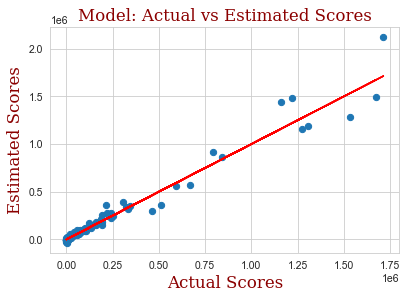

In [18]:
X2_test = sm.add_constant(X2_test)
y2_preds = results2.predict(X2_test)


font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }
plt.figure(dpi = 75)
plt.scatter(y2_test, y2_preds)
plt.plot(y2_test, y2_test, color="red")
plt.xlabel("Actual Scores", fontdict=font)
plt.ylabel("Estimated Scores", fontdict=font)
plt.title("Model: Actual vs Estimated Scores", fontdict=font)
plt.show()

In [21]:
secondApproach = dz.rename(columns={'Close Rate':'Close_Rate', 'Net Sales':'Net_Sales'})
result = smf.ols('Net_Sales_Amount ~ Current_Commission+Close_Rate+Net_Sales', secondApproach).fit()
secondApproach['yhat'] = result.fittedvalues
secondApproach['resid'] = result.resid


result2 = sm.OLS(secondApproach['Net_Sales_Amount'], sm.add_constant(secondApproach[['Current_Commission',
                                                                                     'Close_Rate','Net_Sales']])).fit()
secondApproach['yhat2'] = result2.fittedvalues
secondApproach['resid2'] = result2.resid

secondApproach['predicted'] = result.predict(secondApproach)
secondApproach.to_excel('WH_predictedAmount4.xlsx', index=False)
secondApproach = secondApproach.drop(['yhat', 'resid', 'yhat2', 'resid2'], axis = 1) 

In [29]:
secondApproach.head(1)

,ID,Market,Gate,Handle Time,Current_Commission,Current Comm Per Hour,Commission_Rate,Close_Rate,Net_Sales,Net_Sales_Amount,predicted
0,1022033040,West Hills (English) Outbound,G001,154.21,194.42,1.02,0.00,0.11,358.05,69104.24,84888.59


In [23]:
round(result2.rsquared,2)

0.94

In [24]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score,r2_score
#Linear Regression
df = dz[['Handle Time','Current_Commission','Close Rate','Commission_Rate','Net Sales','Net_Sales_Amount']]

y=df["Net_Sales_Amount"]
x=df[['Current_Commission','Close Rate','Net Sales']]

# define the multiple Linear regression model
linear_regress = LinearRegression()

# Fit the multiple Linear regression model
linear_regress.fit(x,y)

# predict with the data
y_pred = linear_regress.predict(x)

y_pred = pd.DataFrame(y_pred)

In [25]:
accuracy_lr = linear_regress.score(x, y)
print(accuracy_lr)

0.9401110781434457


# Building Model - Monte Carlo simulation model

In [26]:
# Prepare data for the simulation analysis
data = secondApproach[['ID','Handle Time','Current_Commission','Current Comm Per Hour',
                       'Commission_Rate','Close_Rate','Net_Sales','Net_Sales_Amount','predicted']]
data.columns = ['ID','Handle_Time','Current_Commission_Amt','Current_CommAmt_Per_Hour','Commission_Rate',
                'Close_Rate','Net_Sales_Unit','Current_Net_Sales_Amount','Net_Sales_Target_Amt']
data = data.query("~(Net_Sales_Target_Amt < 0)")
data['Percent_To_Plan'] = data['Current_Net_Sales_Amount']/data['Net_Sales_Target_Amt']
data['Target %'] = round(data['Percent_To_Plan']*100,2)
data.head(3)

,ID,Handle_Time,Current_Commission_Amt,Current_CommAmt_Per_Hour,Commission_Rate,Close_Rate,Net_Sales_Unit,Current_Net_Sales_Amount,Net_Sales_Target_Amt,Percent_To_Plan,Target %
0,1022033040,154.21,194.42,1.02,0.00,0.11,358.05,69104.24,84888.59,0.81,81.41
3,1022033040,81.56,63.03,0.29,0.00,0.10,284.97,124975.66,64103.26,1.95,194.96
4,1024436900,418.94,2413.50,6.47,0.01,0.12,543.97,222887.08,203426.14,1.10,109.57


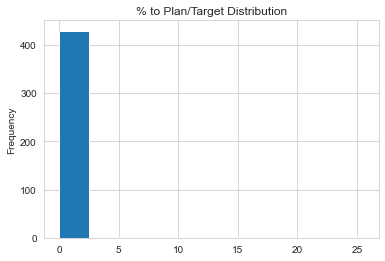

In [24]:
data['Percent_To_Plan'].plot(kind='hist', title='% to Plan/Target Distribution')

In [64]:
data['Percent_To_Plan'].describe(percentiles=[0.00, 0.05,.25, .5, .75, 1.00])

count   435.00
mean      0.96
std       1.52
min       0.00
0%        0.00
5%        0.11
25%       0.58
50%       0.82
75%       1.09
100%     25.55
max      25.55
Name: Percent_To_Plan, dtype: float64

In [26]:
data['Commission_Rate'].describe(percentiles=[0.00, 0.05,.25, .5, .75, 1.00])

count   435.00
mean      0.01
std       0.01
min       0.00
0%        0.00
5%        0.00
25%       0.00
50%       0.01
75%       0.01
100%      0.06
max       0.06
Name: Commission_Rate, dtype: float64

In [27]:
data.shape

(435, 11)

In [28]:
# Define the variables for the Percent to target based on calculated mean = 0.95
avg = 1
std_dev = .1
num_reps = 482
num_simulations = 1000

In [29]:
# Example of calculating the percent to target
pct_to_target = np.random.normal(avg, std_dev, num_reps).round(2)

In [30]:
pct_to_target[0:10]

array([0.99, 0.92, 0.91, 1.07, 1.03, 0.93, 1.12, 0.99, 1.01, 0.84])

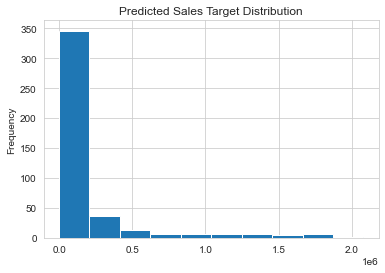

In [31]:
# sales target distribution
data['Net_Sales_Target_Amt'].plot(kind='hist', title='Predicted Sales Target Distribution')

In [33]:
data['Net_Sales_Target_Amt'].describe(percentiles=[0.00, 0.05,.25, .5, .75, 1.00])

count       435.00
mean     203021.31
std      375621.13
min         258.66
0%          258.66
5%         2523.75
25%       23548.50
50%       69519.24
75%      154492.96
100%    2078310.26
max     2078310.26
Name: Net_Sales_Target_Amt, dtype: float64

In [55]:
sales_target_values = [258.66, 10_000, 40_000, 300_000, 400_000, 6000_000]
sales_target_prob = [.3, .3, .2, .1, .05, .05]
new_sales_target = np.random.choice(sales_target_values, num_reps, p=sales_target_prob)

In [32]:
#sales_target_values = [5.17, 20_000, 40_000, 60_000, 80_000, 100_000, 20_000]
#sales_target_prob = [.3, .2, .2, .1, .1, .05, .05]
#new_sales_target = np.random.choice(sales_target_values, num_reps, p=sales_target_prob)

In [35]:
np.set_printoptions(suppress=True)
print(new_sales_target[0:5])

[ 1000.    2000.     258.66 70000.    1000.  ]


In [56]:
# Create dataframe for the new Sales Target (It can Yearly or Quarterly or Monthly).
df = pd.DataFrame(index=range(num_reps), data={'Pct_To_Target': pct_to_target,
                                               'new_sales_target': new_sales_target})
df.head(3)

,Pct_To_Target,new_sales_target
0,1.17,40000.00
1,1.02,40000.00
2,1.02,258.66


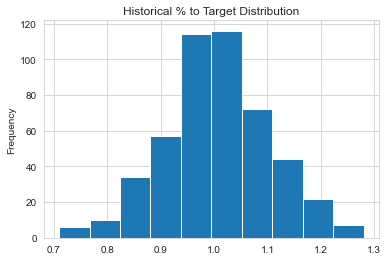

In [37]:
# Simple histogram to confirm distribution looks as expected
df['Pct_To_Target'].plot(kind='hist', title='Historical % to Target Distribution')

In [66]:
commRate_and_plan = data.pivot_table(index=['Commission_Rate','Percent_To_Plan'], aggfunc='size')
commRate_and_plan.tail()

Commission_Rate  Percent_To_Plan
0.05             0.64               1
                 1.42               1
                 5.48               1
                 25.55              1
0.06             0.89               1
dtype: int64

In [39]:
data[data['Commission_Rate'] == data['Commission_Rate'].max()]

,ID,Handle_Time,Current_Commission_Amt,Current_CommAmt_Per_Hour,Commission_Rate,Close_Rate,Net_Sales_Unit,Current_Net_Sales_Amount,Net_Sales_Target_Amt,Percent_To_Plan,Target %
35,1024583110,74.21,984.69,8.77,0.06,0.04,67.05,17130.35,19283.27,0.89,88.84


**Monte Carlo simulation - First Approach**

In [68]:
def calc_commission_rate(x):
    """ Return the commission rate based on the data:
    0-90% = 2%
    91-99% = 3%
    >= 100 = 4%
    """
    
    if x <= 1.0:
        return .02
    if x <= 1.5:
        return .03
    if x <= 2.0:
        return .04
    else:
        return .06
    
df['New_Commission_Rate'] = df['Pct_To_Target'].apply(calc_commission_rate)

dz = df.copy()
dz.insert(0, 'Unique_ID', range(10, 10 + len(dz)))

df_dat = data[['ID','Handle_Time','Current_Commission_Amt','Current_CommAmt_Per_Hour','Commission_Rate',
                'Close_Rate','Current_Net_Sales_Amount']]
df_dat.insert(0, 'Unique_ID', range(10, 10 + len(df_dat)))
merge = (pd.merge(df_dat, dz, on=['Unique_ID'], copy = False))

# Calculate the proposed commissions  amount
merge['New_Commission_Amount'] = merge['New_Commission_Rate'] * merge['Current_Net_Sales_Amount']

print(merge['Current_Net_Sales_Amount'].sum(), merge['Commission_Rate'].mean(), 
      merge['New_Commission_Rate'].mean(), merge['new_sales_target'].sum())

87177029.88 0.009356321839080403 0.024896551724137735 166682591.16000003


**Use Closed Rate values to get new commission rate - Second Approach**

In [41]:
desc = data[['Commission_Rate','Close_Rate']]
desc.describe()

,Commission_Rate,Close_Rate
count,435.00,435.00
mean,0.01,0.19
std,0.01,0.16
min,0.00,0.01
25%,0.00,0.07
50%,0.01,0.12
75%,0.01,0.30
max,0.06,0.67


In [69]:
def calc_commission_rate(x):
    """ Return the commission rate based on Closed Rate values:
    0-20% = 2%
    11-30% = 4%
    >= 67 = 4%
    """
    if x <= .20:
        return .02
    if x <= .30:
        return .04
    else:
        return .06

# Define a list to keep all the results from each simulation that we want to analyze
all_stats = []

# Loop through many simulations
for i in range(num_simulations):
    
    # Choose random inputs for the sales targets and percent to target
    new_sales_target = np.random.choice(sales_target_values, num_reps, p=sales_target_prob)
    pct_to_target = np.random.normal(avg, std_dev, num_reps).round(2)
    
    # Build the dataframe based on the inputs and number of reps
    df = pd.DataFrame(index=range(num_reps), data={'Pct_To_Target': pct_to_target,
                                                   'new_sales_target': new_sales_target})
    df.insert(0, 'New_ID', range(10, 10 + len(df)))

    df_data = data[['ID','Handle_Time','Current_Commission_Amt','Current_CommAmt_Per_Hour','Commission_Rate',
                'Close_Rate','Current_Net_Sales_Amount']]
    df_data.insert(0, 'New_ID', range(10, 10 + len(df_data)))
    df_merge = (pd.merge(df_data, df, on=['New_ID'], copy = False))
   
    
    # Determine the commissions rate and calculate it
    df_merge['New_Commission_Rate'] = df_merge['Pct_To_Target'].apply(calc_commission_rate)
    df_merge['New_Commission_Amount'] = df_merge['New_Commission_Rate'] * df_merge['new_sales_target']
    
    # We want to track sales,commission amounts and sales targets over all the simulations
    all_stats.append([df_merge['Current_Net_Sales_Amount'].sum().round(0), 
                      df_merge['Current_Commission_Amt'].sum().round(0),
                      df_merge['New_Commission_Amount'].sum().round(0),
                      df_merge['new_sales_target'].sum().round(0)])

In [70]:
results_df = pd.DataFrame.from_records(all_stats, columns=['Current_Net_Sales_Amount','Current_Commission_Amt',
                                                           'New_Commission_Amount','new_sales_target'])

**Compare results**

In [71]:
#Standard simulation technique results - using Sales Target values

print(merge['Current_Net_Sales_Amount'].sum().round(0), round(merge['Commission_Rate'].mean(),2), 
      round(merge['New_Commission_Rate'].mean(),2), merge['new_sales_target'].sum().round(0))

87177030.0 0.01 0.02 166682591.0


In [61]:
# Simulation results - Using Close Rate and Commission Rate

print(df_merge['Current_Net_Sales_Amount'].sum().round(0), round(df_merge['Commission_Rate'].mean(),2), 
      round(df_merge['New_Commission_Rate'].mean(),2), df_merge['new_sales_target'].sum().round(0))

87177030.0 0.01 0.06 166682591.0


In [63]:
#results_df.describe().round(0).style.format('{:,}')